# Predictions using Machine Learning
# Loading and preparing data

In [41]:
import sys
sys.path.append('../')
import pandas as pd
from utilities.data_manager import ExchangeDataManager

exchange_name = "binance"
pair = "ETH/USDT"
coin = pair.split('/')[0]
tf = "1d"

exchange = ExchangeDataManager(
    exchange_name=exchange_name, 
    path_download="../database/exchanges"
)

df = exchange.load_data(
    coin=pair, 
    interval=tf
)
df.tail()

,open,high,low,close,volume
date,,,,,
2024-01-23,2314.19,2352.23,2168.07,2242.60,700105.3314
2024-01-24,2242.60,2264.60,2196.12,2235.02,359851.1496
2024-01-25,2235.02,2242.89,2171.30,2218.64,330426.6061
2024-01-26,2218.64,2282.36,2195.84,2267.68,363566.4255
2024-01-27,2267.67,2282.94,2251.40,2267.94,145109.3836


In [42]:
#Check if any zero volumes are available
indexZeros = df[ df['volume'] == 0 ].index

df.drop(indexZeros , inplace=True)
df.loc[(df["volume"] == 0 )]
df.isna().sum()

open      0
high      0
low       0
close     0
volume    0
dtype: int64

In [43]:
import numpy as np
import pandas_ta as ta
#df.ta.indicators()
#help(ta.atr)
df['ATR'] = df.ta.atr(length=20)
df['RSI'] = df.ta.rsi()
df['Average'] = df.ta.midprice(length=1) #midprice
df['MA40'] = df.ta.sma(length=40)
df['MA80'] = df.ta.sma(length=80)
df['MA160'] = df.ta.sma(length=160)

from scipy.stats import linregress
def get_slope(array):
    y = np.array(array)
    x = np.arange(len(y))
    slope, intercept, r_value, p_value, std_err = linregress(x,y)
    return slope

#!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
backrollingN = 6
#!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
df['slopeMA40'] = df['MA40'].rolling(window=backrollingN).apply(get_slope, raw=True)
df['slopeMA80'] = df['MA80'].rolling(window=backrollingN).apply(get_slope, raw=True)
df['slopeMA160'] = df['MA160'].rolling(window=backrollingN).apply(get_slope, raw=True)
df['AverageSlope'] = df['Average'].rolling(window=backrollingN).apply(get_slope, raw=True)
df['RSISlope'] = df['RSI'].rolling(window=backrollingN).apply(get_slope, raw=True)

In [44]:
df.tail()

,open,high,low,close,volume,ATR,RSI,Average,MA40,MA80,MA160,slopeMA40,slopeMA80,slopeMA160,AverageSlope,RSISlope
date,,,,,,,,,,,,,,,,
2024-01-23,2314.19,2352.23,2168.07,2242.60,700105.3314,112.563794,40.340979,2260.150,2348.08300,2223.283125,1939.510375,3.588714,7.171529,3.539330,-39.318857,-3.064148
2024-01-24,2242.60,2264.60,2196.12,2235.02,359851.1496,110.359604,39.954425,2230.360,2348.44600,2227.574500,1942.969938,2.314550,6.257693,3.332455,-53.367429,-3.715343
2024-01-25,2235.02,2242.89,2171.30,2218.64,330426.6061,108.421124,39.082899,2207.095,2348.18800,2231.545625,1946.451500,0.793107,5.339871,3.226091,-61.860143,-3.421281
2024-01-26,2218.64,2282.36,2195.84,2267.68,363566.4255,107.326068,43.085648,2239.100,2349.96700,2236.325750,1950.189063,0.065971,4.659746,3.273686,-48.666143,-1.888056
2024-01-27,2267.67,2282.94,2251.40,2267.94,145109.3836,103.536764,43.106993,2267.170,2351.17975,2241.073500,1953.830938,0.336793,4.464061,3.448789,-19.279714,0.071102


# Target categories

In [45]:
#Target flexible way
pipdiff = 500*1e-5 #for TP
SLTPRatio = 2 #pipdiff/Ratio gives SL

def mytarget(barsupfront, df1):
    length = len(df1)
    high = list(df1['high'])
    low = list(df1['low'])
    close = list(df1['close'])
    open = list(df1['open'])
    trendcat = [None] * length
    
    for line in range (0,length-barsupfront-2):
        valueOpenLow = 0
        valueOpenHigh = 0
        for i in range(1,barsupfront+2):
            value1 = open[line+1]-low[line+i]
            value2 = open[line+1]-high[line+i]
            valueOpenLow = max(value1, valueOpenLow)
            valueOpenHigh = min(value2, valueOpenHigh)

            if ( (valueOpenLow >= pipdiff) and (-valueOpenHigh <= (pipdiff/SLTPRatio)) ):
                trendcat[line] = 1 #-1 downtrend
                break
            elif ( (valueOpenLow <= (pipdiff/SLTPRatio)) and (-valueOpenHigh >= pipdiff) ):
                trendcat[line] = 2 # uptrend
                break
            else:
                trendcat[line] = 0 # no clear trend
            
    return trendcat

In [46]:
# mytarget(barsfront to take into account, dataframe)
df['mytarget'] = mytarget(16, df)
df.head()

,open,high,low,close,volume,ATR,RSI,Average,MA40,MA80,MA160,slopeMA40,slopeMA80,slopeMA160,AverageSlope,RSISlope,mytarget
date,,,,,,,,,,,,,,,,,
2017-08-17,301.13,312.18,298.00,302.00,7030.71034,NaN,NaN,305.090,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2017-08-18,302.00,311.79,283.94,293.96,9537.84646,NaN,NaN,297.865,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2017-08-19,293.31,299.90,278.00,290.91,2146.19773,NaN,NaN,288.950,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2017-08-20,289.41,300.53,282.85,299.10,2510.13871,NaN,NaN,291.690,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2017-08-21,299.10,346.52,294.60,323.29,5219.44542,NaN,NaN,320.560,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0


# Quick analysis example

C:\Users\jacks\AppData\Local\Temp\ipykernel_176516\2271519335.py:5: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  df_model.hist(ax = ax)


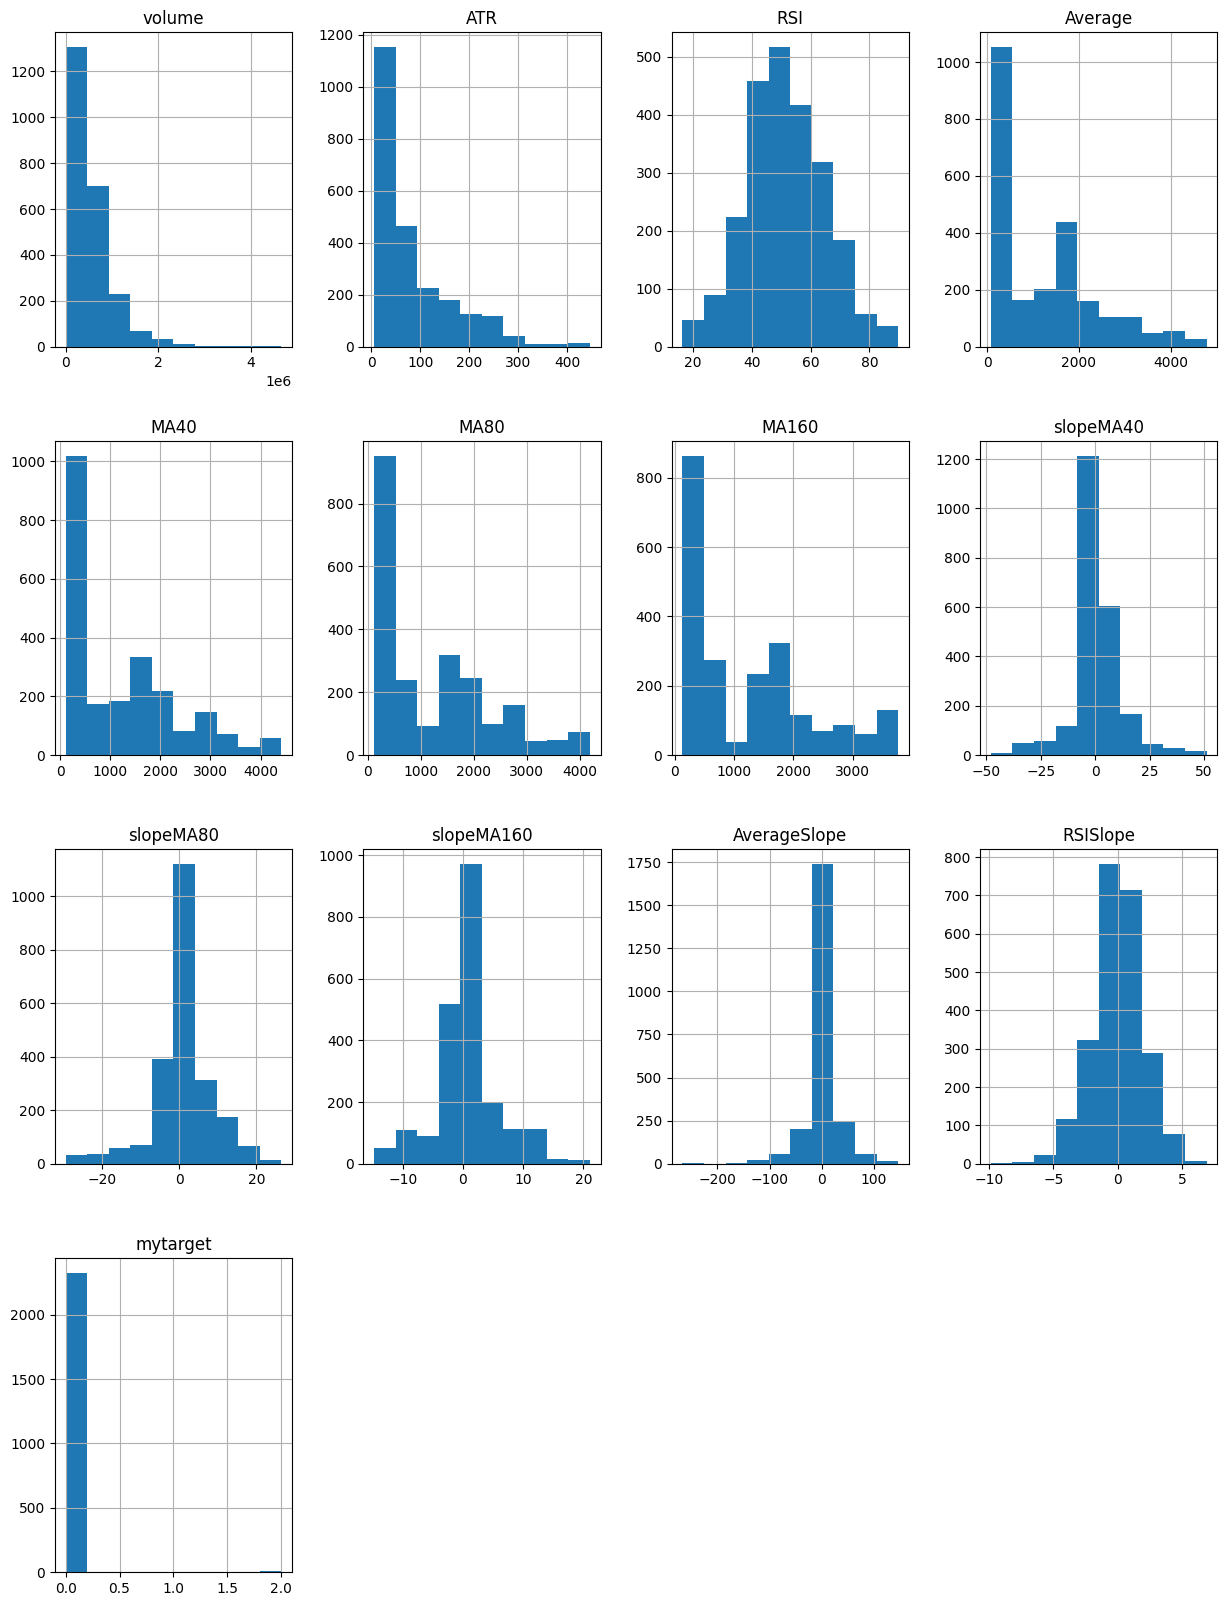

In [47]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize = (15,20))
ax = fig.gca()
df_model= df[['volume', 'ATR', 'RSI', 'Average', 'MA40', 'MA80', 'MA160', 'slopeMA40', 'slopeMA80', 'slopeMA160', 'AverageSlope', 'RSISlope', 'mytarget']] 
df_model.hist(ax = ax)
plt.show()

## Can we use the RSI alone as a trend indicator?

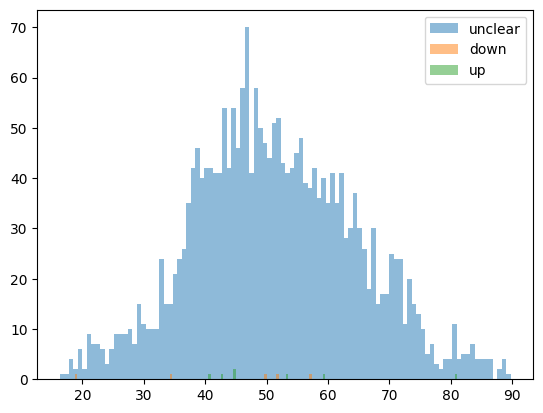

In [48]:
from matplotlib import pyplot
df_up=df.RSI[ df['mytarget'] == 2 ]
df_down=df.RSI[ df['mytarget'] == 1 ]
df_unclear=df.RSI[ df['mytarget'] == 0 ]
pyplot.hist(df_unclear, bins=100, alpha=0.5, label='unclear')
pyplot.hist(df_down, bins=100, alpha=0.5, label='down')
pyplot.hist(df_up, bins=100, alpha=0.5, label='up')

pyplot.legend(loc='upper right')
pyplot.show()

# Machine learning for trend prediction

## 1 - the perfect model with precise prediction

## 2 - less perfect model still with > 40% precision

## 3 - much less perfect model with precision >35% taking into account our strategy, and our TP/SL ratio 

### can't let an automated program run your trades
### it can be your version of a smart indicator (based on machine learning)

## 4 - Our target has categorical values so we need a classificator, KNN?

## Splitting features and target

In [49]:
df_model=df_model.dropna()

attributes=['ATR', 'RSI', 'Average', 'MA40', 'MA80', 'MA160', 'slopeMA40', 'slopeMA80', 'slopeMA160', 'AverageSlope', 'RSISlope']
X = df_model[attributes]
y = df_model["mytarget"]

print(X)

                   ATR        RSI   Average        MA40         MA80  \
date                                                                   
2018-01-28  147.288328  62.571900  1194.500   973.75600   718.504875   
2018-01-29  144.785384  57.450966  1210.270   983.42600   729.548750   
2018-01-30  144.338525  51.869324  1118.925   991.00325   739.242250   
2018-01-31  142.421234  53.939524  1082.000  1003.22425   749.486875   
2018-02-01  144.500048  49.140943  1072.995  1013.26425   758.598750   
...                ...        ...       ...         ...          ...   
2024-01-05   99.273596  50.887954  2241.690  2242.86225  2066.871125   
2024-01-06   96.989916  48.587064  2243.200  2248.19425  2075.337875   
2024-01-07   94.867920  47.004531  2230.735  2252.52625  2083.523500   
2024-01-08   99.715524  55.745759  2262.290  2260.06700  2092.605375   
2024-01-09  101.976748  56.722378  2299.250  2267.37525  2101.547250   

                  MA160  slopeMA40  slopeMA80  slopeMA160  Aver

In [50]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

## Fitting the KNN model

In [51]:
from sklearn.neighbors import KNeighborsClassifier

model = KNeighborsClassifier(n_neighbors=500, weights='uniform', algorithm='kd_tree', leaf_size=30, p=1, metric='minkowski', metric_params=None, n_jobs=4)
model.fit(X_train, y_train)

y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

## Quick evaluation of our fitting

In [52]:
from sklearn.metrics import accuracy_score
accuracy_train = accuracy_score(y_train, y_pred_train)
accuracy_test = accuracy_score(y_test, y_pred_test)
print("Accuracy train: %.2f%%" % (accuracy_train * 100.0))
print("Accuracy test: %.2f%%" % (accuracy_test * 100.0))

#------------------------------------------------------------------
#--- How should I compare my accuracy ?
print(df_model['mytarget'].value_counts()*100/df_model['mytarget'].count())

# Random Model, gambler?
pred_test = np.random.choice([0, 1, 2], len(y_pred_test))
accuracy_test = accuracy_score(y_test, pred_test)
print("Accuracy Gambler: %.2f%%" % (accuracy_test * 100.0))

Accuracy train: 99.42%
Accuracy test: 100.00%
mytarget
0.0    99.539807
2.0     0.230097
1.0     0.230097
Name: count, dtype: float64
Accuracy Gambler: 34.02%


## More powerful model XGBoost

In [53]:
from xgboost import XGBClassifier
model = XGBClassifier()
model.fit(X_train, y_train)
pred_train = model.predict(X_train)
pred_test = model.predict(X_test)
acc_train = accuracy_score(y_train, pred_train)
acc_test = accuracy_score(y_test, pred_test)
print('****Train Results****')
print("Accuracy: {:.4%}".format(acc_train))
print('****Test Results****')
print("Accuracy: {:.4%}".format(acc_test))

****Train Results****
Accuracy: 100.0000%
****Test Results****
Accuracy: 100.0000%


## !!Data sampling shouldn't be random

In [54]:
#random sampling
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

#sequential sampling
train_index = int(0.8 * len(X))
X_train, X_test = X[:train_index], X[train_index:]
y_train, y_test = y[:train_index], y[train_index:]

model = XGBClassifier()
model.fit(X_train, y_train)
pred_train = model.predict(X_train)
pred_test = model.predict(X_test)
acc_train = accuracy_score(y_train, pred_train)
acc_test = accuracy_score(y_test, pred_test)
print('****Train Results****')
print("Accuracy: {:.4%}".format(acc_train))
print('****Test Results****')
print("Accuracy: {:.4%}".format(acc_test))

****Train Results****
Accuracy: 100.0000%
****Test Results****
Accuracy: 100.0000%


## Which features are most important for our model?

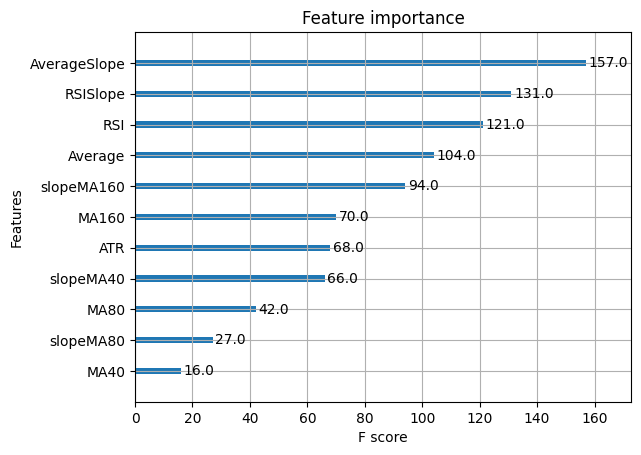

In [55]:
from matplotlib import pyplot
from xgboost import plot_importance
#plot feature importance
plot_importance(model)
pyplot.show()

# Automated orders using python and Machine Learning
## Previous videos
### 1 - Install Anaconda, Jupyter NB, Pandas_TA (Technical Analysis)
### 2 - Download price data from online resources, and add our technical indicators to our exchange price dataframe
### 3 - Fit a Machine learning model and predict future price trends using KNN and XGBOOST classifiers
### 4 - Save and Load a ML model,
### - according to the model's advice
### - passing orders (sell/buy) automatically
### - send an email notification about newly applied trading operations

## Load Machine Learning Model from Disk and Test it

In [20]:
import joblib

# save your ML model to disk
filename = 'mymodel1.sav'
joblib.dump(model, filename)

#load the model from disk
loaded_model = joblib.load('mymodel1.sav')

## Live Automated Orders with email notification

In [32]:
from apscheduler.schedulers.blocking import BlockingScheduler
import json
from oandapyV20 import API
import oandapyV20.endpoints.orders as orders
from oandapyV20.contrib.requests import MarketOrderRequest
from oanda_candles import Pair, Gran, CandleCollector
from oandapyV20.contrib.requests import TakeProfitDetails, StopLossDetails


import smtplib
gmail_user = 'email@gmail.com'
gmail_password = 'email password here'
sent_from = gmail_user
to = ['email@gmail.com']
subject = 'info CHF'


In [30]:
ModelPrediction = 0
def some_job():
    access_token="INSERT TOKEN HERE, YOU GET IT FROM YOUR OANDA ACCOUNT"
    collector = CandleCollector(access_token, Pair.USD_CHF, Gran.H4)
    candles = collector.grab(2*161)

    dfstream = pd.DataFrame(columns=['Open','Close','High','Low'])
    i=0
    for candle in candles:
        dfstream.loc[i, ['Open']] = float(str(candle.bid.o))
        dfstream.loc[i, ['Close']] = float(str(candle.bid.c))
        dfstream.loc[i, ['High']] = float(str(candle.bid.h))
        dfstream.loc[i, ['Low']] = float(str(candle.bid.l))
        i=i+1

    dfstream['Open'] = dfstream['Open'].astype(float)
    dfstream['Close'] = dfstream['Close'].astype(float)
    dfstream['High'] = dfstream['High'].astype(float)
    dfstream['Low'] = dfstream['Low'].astype(float)

    #dfstream['Average'] = (dfstream['High']+dfstream['Low'])/2
    #dfstream['MA40'] = dfstream['Open'].rolling(window=40).mean()
    #dfstream['MA80'] = dfstream['Open'].rolling(window=80).mean()
    #dfstream['MA160'] = dfstream['Open'].rolling(window=160).mean()
    
    import numpy as np
    import pandas_ta as ta
    #attributes=['ATR', 'RSI', 'Average', 
    #'MA40', 'MA80', 'MA160', 'slopeMA40', 
    #'slopeMA80', 'slopeMA160', 'AverageSlope', 'RSISlope']
    dfstream['ATR'] = dfstream.ta.atr(length=20)
    dfstream['RSI'] = dfstream.ta.rsi()
    dfstream['Average'] = dfstream.ta.midprice(length=1) #midprice
    dfstream['MA40'] = dfstream.ta.sma(length=40)
    dfstream['MA80'] = dfstream.ta.sma(length=80)
    dfstream['MA160'] = dfstream.ta.sma(length=160)

#from scipy.stats import linregress
#def get_slope(array):
#    y = np.array(array)
#    x = np.arange(len(y))
#    slope, intercept, r_value, p_value, std_err = linregress(x,y)
#    return slope

    #!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
    backrollingN = 6
    #!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
    dfstream['slopeMA40'] = dfstream['MA40'].rolling(window=backrollingN).apply(get_slope, raw=True)
    dfstream['slopeMA80'] = dfstream['MA80'].rolling(window=backrollingN).apply(get_slope, raw=True)
    dfstream['slopeMA160'] = dfstream['MA160'].rolling(window=backrollingN).apply(get_slope, raw=True)
    dfstream['AverageSlope'] = dfstream['Average'].rolling(window=backrollingN).apply(get_slope, raw=True)
    dfstream['RSISlope'] = dfstream['RSI'].rolling(window=backrollingN).apply(get_slope, raw=True)

    #________________________________________________________________________________________________
    X_stream = dfstream.iloc[[320]]# !!! Index takes last CLOSED candle
    #attributes=['ATR', 'RSI', 'Average', 'MA40', 'MA80', 'MA160', 
    #'slopeMA40', 'slopeMA80', 'slopeMA160', 'AverageSlope', 'RSISlope']
    X_model = X_stream[attributes]
    
    # Apply the model for predictions
    ModelPrediction = loaded_model.predict(X_model)
  
    msg = str(ModelPrediction) # 0 no clear trend, 1 downtrend, 2 uptrend
    #------------------------------------
    # send email with 
    server = smtplib.SMTP_SSL('smtp.gmail.com', 465)
    server.ehlo()
    server.login(gmail_user, gmail_password)
    server.sendmail(sent_from, to, msg)
    server.close()
    #________________________________________________________________________________________________
    
    
    # EXECUTING ORDERS
    accountID = "1432-432-0000" #use your account ID
    client = API(access_token)

    candles = collector.grab(1)
#    for candle in candles:
#        print(candle.bid.o)
#        print(candle.bid.c)
    
    pipdiff = 500*1e-5 #for TP
    SLTPRatio = 2 #pipdiff/Ratio gives SL
    
    TPBuy = float(str(candle.bid.o))+pipdiff
    SLBuy = float(str(candle.bid.o))-(pipdiff/SLTPRatio)
    TPSell = float(str(candle.bid.o))-pipdiff
    SLSell = float(str(candle.bid.o))+(pipdiff/SLTPRatio)
    
    #Sell
    if ModelPrediction == 1:
        mo = MarketOrderRequest(instrument="USD_CHF", units=-1000, takeProfitOnFill=TakeProfitDetails(price=TPSell).data, stopLossOnFill=StopLossDetails(price=SLSell).data)
        r = orders.OrderCreate(accountID, data=mo.data)
        rv = client.request(r)
        print(rv)
    #Buy
    elif ModelPrediction == 2:
        mo = MarketOrderRequest(instrument="USD_CHF", units=1000, takeProfitOnFill=TakeProfitDetails(price=TPBuy).data, stopLossOnFill=StopLossDetails(price=SLBuy).data)
        r = orders.OrderCreate(accountID, data=mo.data)
        rv = client.request(r)
        print(rv)

## Executing orders automatically every 4 Hours

In [33]:
#some_job()

###################################################################
## Interval time job ##############################################
scheduler = BlockingScheduler(job_defaults={'misfire_grace_time': 15*60})
scheduler.add_job(some_job, 'cron', day_of_week='mon-fri', hour='*/4', minute=5, jitter=120, timezone='America/New_York')
#scheduler.add_job(some_job, 'interval', hours=4)
scheduler.start()

V20Error: {"errorMessage":"Insufficient authorization to perform request."}